In [1]:
%load_ext lineapy

/home/mingjerli/miniconda3/envs/lineapy39/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
art_agg = lineapy.get('agg')
art_summary = lineapy.get('summary')

ac = lineapy.graph_reader.artifact_collection.ArtifactCollection(art_agg.db, [{'artifact_name':'agg'},{'artifact_name':'summary'}], input_parameters=['nsample'])

import matplotlib.pyplot as plt
import networkx as nx
import pydot
from networkx.drawing.nx_pydot import graphviz_layout
from lineapy.graph_reader.program_slice import get_source_code_from_graph

statements = []

for said, sa in ac.session_artifacts.items():
    for node_id in list(nx.topological_sort(sa.session_graph.nx_graph)):
        node = sa.session_graph.get_node(node_id)
        source_code = get_source_code_from_graph(set([node.id]), sa.session_graph)
        if str(source_code)!='':
            # print(node.source_location.__dict__)
            source_code_id = node.source_location.source_code.id
            statement = {
                'node_id':node_id,
                'source_code_id':node.source_location.source_code.id,
                'code_text':node.source_location.source_code.code.split('\n'),
                'lineno':node.source_location.lineno,
                'col_offset':node.source_location.col_offset,
                'end_lineno':node.source_location.end_lineno,
                'end_col_offset':node.source_location.end_col_offset
            }
            statement['actual_code'] = '\n'.join(statement['code_text'][
                (statement['lineno']-1):statement['end_lineno']
            ])
            statements.append(statement)
            
statements.sort(key= lambda x: x['lineno'])
            

import_nodes = sa.import_nodes
input_parameters_node = set(sa.input_parameters_node.values())


all_nodes = set([s['node_id'] for s in statements])
agg_nodes=set(art_agg._get_subgraph().nx_graph.nodes)
summary_nodes=set(art_summary._get_subgraph().nx_graph.nodes)

In [3]:
def process_color(node_spec, statements, default_color='black'):

    node_color = {}
    for col, nodes in node_spec.items():
        for node in nodes:
            node_color[node]=col

    node_shape = {}

    statement_color = dict()
    for s in statements:
        if (s['lineno'],s['end_lineno'],s['actual_code']) in statement_color.keys():
            statement_color[(s['lineno'],s['end_lineno'],s['actual_code'])].add(node_color[s['node_id']])
        else:
            statement_color[(s['lineno'],s['end_lineno'],s['actual_code'])] = {node_color[s['node_id']]}         

    for k, cols in statement_color.items():
        if len(cols)>1 and default_color in cols:
            cols.remove(default_color)
        assert len(cols)==1
        # cols = cols.pop()

        statement_color[k] = list(cols)[0]

    statements_colororder = sorted(list(statement_color.keys()), key=lambda x: x[0])        
    
    return node_color, statements_colororder, statement_color

def plot_code(statements, statements_colororder, statement_color, fname=None):
    nline = statements[-1]['end_lineno']
    fig = plt.figure(figsize=(16,nline/2), dpi=48)
    ax = fig.add_subplot()
    ax.axis([0, 10, 0, nline])

    for lineno, end_lineno, code in statements_colororder:
        ax.text(0, nline+1-lineno, code, fontsize=20, verticalalignment='top', color=statement_color[(lineno, end_lineno, code)])
        
    ax.axis('off')
    plt.margins(0)
    if fname is not None:
        plt.savefig(fname, format='png')
    else:
        plt.show()
    
def plot_graph(sa, node_color, artifact_nodes, default_color='black',fname=None):
    G = sa.session_graph.nx_graph
    color_map = [node_color.get(n, default_color) for n in G]
    size_map = [800 if n in artifact_nodes else 200 for n in G]
    fig = plt.figure(figsize=(8,6), dpi=48)
    pos = graphviz_layout(G, prog="dot")
    nx.draw(G, pos, node_color=color_map, node_size=size_map)
    plt.margins(0)
    if fname is not None:
        plt.savefig(fname, format='png')
    else:
        plt.show()

    

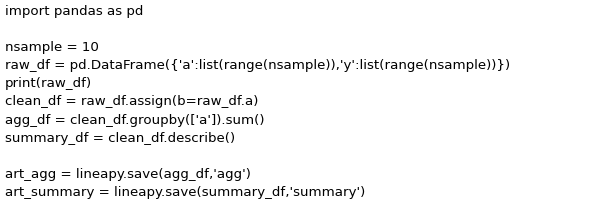

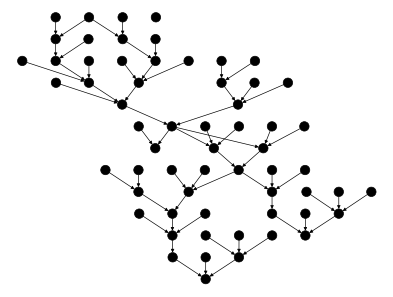

In [4]:
fig_name = 'session_graph'
default_color = 'black'

artifact_nodes = []
node_spec = {
    default_color: all_nodes
}

node_color, statements_colororder, statement_color = process_color(node_spec, statements, default_color)
plot_code(statements, statements_colororder, statement_color, f'{fig_name}_code.png')
plot_graph(sa, node_color, artifact_nodes, default_color, f'{fig_name}.png')

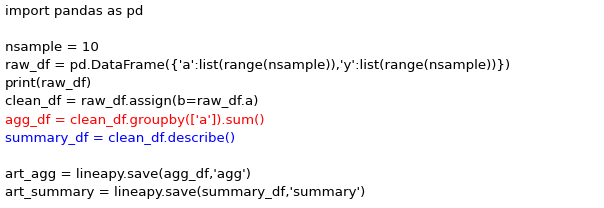

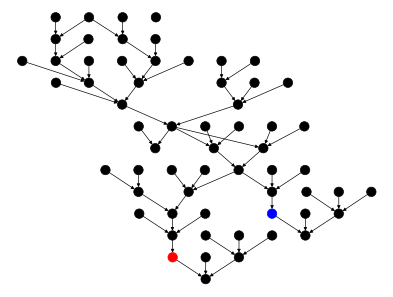

In [5]:
fig_name = 'art1_node'
default_color = 'black'

art_agg_nodes = set([art_agg._node_id])
art_summary_nodes = set([art_summary._node_id])
node_spec = {
    'red': art_agg_nodes,
    'blue': art_summary_nodes,
    default_color: all_nodes-art_agg_nodes-art_summary_nodes
}

# artifact_nodes = set([art_agg._node_id])
# node_spec = {
#     'red': artifact_nodes,
#     default_color: all_nodes-artifact_nodes
# }

node_color, statements_colororder, statement_color = process_color(node_spec, statements, default_color)
plot_code(statements, statements_colororder, statement_color, f'{fig_name}_code.png')
plot_graph(sa, node_color, artifact_nodes, default_color, f'{fig_name}.png')

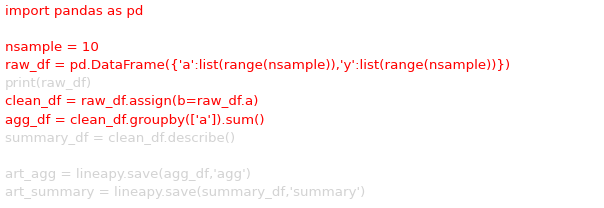

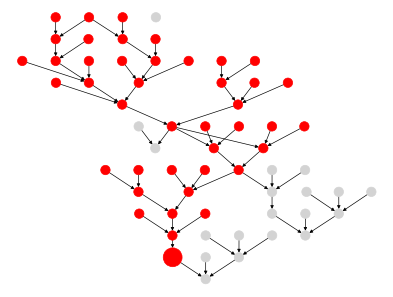

In [6]:
fig_name = 'art1_graph'
default_color = 'lightgray'

artifact_nodes = set([art_agg._node_id])
node_spec = {
    'red': agg_nodes,
    default_color: all_nodes-agg_nodes
}

node_color, statements_colororder, statement_color = process_color(node_spec, statements, default_color)
plot_code(statements, statements_colororder, statement_color, f'{fig_name}_code.png')
plot_graph(sa, node_color, artifact_nodes, default_color, f'{fig_name}.png')

In [7]:
print(art_agg.get_code())

import pandas as pd

nsample = 10
raw_df = pd.DataFrame({"a": list(range(nsample)), "y": list(range(nsample))})
clean_df = raw_df.assign(b=raw_df.a)
agg_df = clean_df.groupby(["a"]).sum()



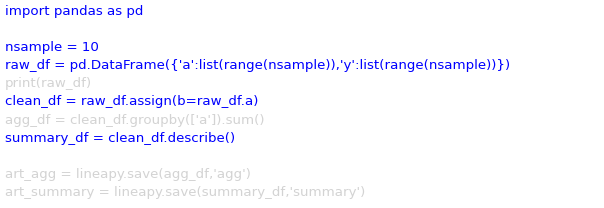

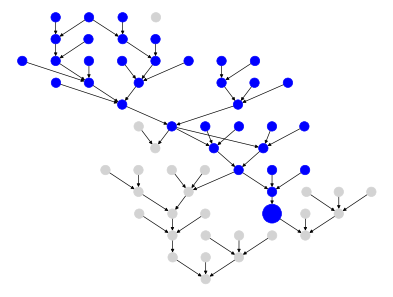

In [8]:
fig_name = 'art2_graph'

artifact_nodes = [art_summary._node_id]
node_spec = {
    'blue': summary_nodes,
    default_color: all_nodes-summary_nodes
}

node_color, statements_colororder, statement_color = process_color(node_spec, statements, default_color)
plot_code(statements, statements_colororder, statement_color, f'{fig_name}_code.png')
plot_graph(sa, node_color, artifact_nodes, default_color, f'{fig_name}.png')

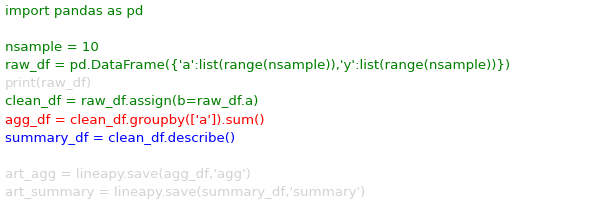

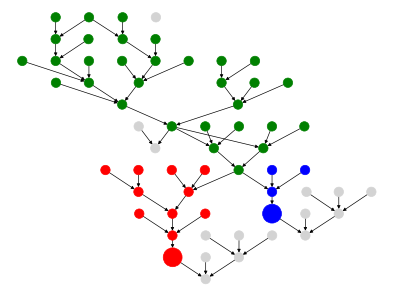

In [9]:
fig_name = 'combine_graph'

artifact_nodes = [art_agg._node_id, art_summary._node_id]
node_spec = {
    'red': agg_nodes-summary_nodes,
    'blue': summary_nodes-agg_nodes,
    'green': agg_nodes&summary_nodes,
    default_color: all_nodes-agg_nodes-summary_nodes
}

node_color, statements_colororder, statement_color = process_color(node_spec, statements, default_color)
plot_code(statements, statements_colororder, statement_color, f'{fig_name}_code.png')
plot_graph(sa, node_color, artifact_nodes, default_color, f'{fig_name}.png')

In [10]:
print(lineapy.get_module_definition(['agg','summary']))


import pandas as pd


def get_clean_df_for_artifact_summary_and_downstream():
    nsample = 10
    raw_df = pd.DataFrame({"a": list(range(nsample)), "y": list(range(nsample))})
    clean_df = raw_df.assign(b=raw_df.a)
    return clean_df


def get_summary(clean_df):
    summary_df = clean_df.describe()
    return summary_df


def get_agg(clean_df):
    agg_df = clean_df.groupby(["a"]).sum()
    return agg_df


def run_session_including_summary():
    # Given multiple artifacts, we need to save each right after
    # its calculation to protect from any irrelevant downstream
    # mutations (e.g., inside other artifact calculations)
    import copy

    artifacts = dict()
    clean_df = get_clean_df_for_artifact_summary_and_downstream()
    summary_df = get_summary(clean_df)
    artifacts["summary"] = copy.deepcopy(summary_df)
    agg_df = get_agg(clean_df)
    artifacts["agg"] = copy.deepcopy(agg_df)
    return artifacts


def run_all_sessions():
    artifacts = dict()
    artifacts.upd